In [1]:
from experiments import covid_example
from emm.reweighting import marginal
from emm.losses import LeastSquaresLoss
from emm.losses import EqualityLoss
from emm.regularizers import EntropyRegularizer
import emm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Plot styles
plt.style.use('seaborn-notebook')

import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Import target and corpus data
target = covid_example.get_target()
corpus = covid_example.get_corpus()
marg_tab = target.groupby('Outcome').mean().T

print("Target statistics: summary statistics conditional on label")
display(marg_tab)

Target statistics: summary statistics conditional on label


Outcome,0.0,1.0
age_60_and_above,0.168484,0.192170
gender,0.494535,0.554499
cough,0.134561,0.448013
fever,0.060829,0.378266
sore_throat,0.001406,0.103612
shortness_of_breath,0.001479,0.079033
head_ache,0.000569,0.151752


In [3]:
# Generate marginal objects using least squares loss function

margs = {}
margs[0] = []
margs[1] = []
for feature in marg_tab.index:
    margs[0].append(marginal(feature,'mean', 
                               LeastSquaresLoss(marg_tab.loc[feature,0])))
    margs[1].append(marginal(feature,'mean', 
                               LeastSquaresLoss(marg_tab.loc[feature,1])))
    

rwc = emm.reweighting.generate_synth(corpus,margs,
                                           regularizer=EntropyRegularizer(), 
                                           lam=0.01,
                                           verbose=True)

CVX took 82.32165 seconds
CVX took 98.80016 seconds


In [4]:
# Display corpus marginals
out_0 = rwc[rwc["Outcome"]==0].drop(columns=["Outcome", "weights"]).T @ rwc[rwc["Outcome"]==0]["weights"] * 2
out_1 = rwc[rwc["Outcome"]==1].drop(columns=["Outcome", "weights"]).T @ rwc[rwc["Outcome"]==1]["weights"] * 2
rw_marg_tab = pd.DataFrame([out_0, out_1]).T
print("Reweighted corpus statistics")
display(rw_marg_tab)
print("Absolute difference between target and corpus statistics")
display(abs(marg_tab - rw_marg_tab)/abs(marg_tab) * 100)

Reweighted corpus statistics


,0,1
age_60_and_above,0.172380,0.195282
gender,0.493611,0.552538
cough,0.125397,0.433280
fever,0.054242,0.363130
sore_throat,0.006859,0.100396
shortness_of_breath,0.008975,0.074832
head_ache,0.001788,0.137175


Absolute difference between target and corpus statistics


Outcome,0.0,1.0
age_60_and_above,2.312404,1.619055
gender,0.186812,0.353551
cough,6.810576,3.288425
fever,10.829062,4.001549
sore_throat,387.706266,3.103998
shortness_of_breath,506.611749,5.315072
head_ache,214.325474,9.605511


## Machine learning

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

param_grid = {  'classifier' : [LGBMClassifier()],
                'classifier__num_leaves': [5,10],
                'classifier__min_data_in_leaf': [1,3],
                'classifier__feature_fraction': [0.4],
                'classifier__bagging_fraction': [0.7],
                'classifier__bagging_freq': [8],
                'classifier__learning_rate': [0.05],
                'classifier__num_boost_round' : [400],
                'classifier__n_estimators' : [10,30],  
             }


target_clf, weighted_clf, scores = emm.metrics.classifier_metric(target,
                                                         rwc,
                                                         param_grid,
                                                         return_models=True,
                                                         verbose=True, 
                                                         scoring=roc_auc_score,
                                                         metrics=[accuracy_score, roc_auc_score, confusion_matrix])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Target data: the best parameters are given by 
 LGBMClassifier(bagging_fraction=0.7, bagging_freq=8, feature_fraction=0.4,
               learning_rate=0.05, min_data_in_leaf=1, n_estimators=10,
               num_boost_round=400, num_leaves=5)
 the best mean cross-validation accuracy 76.860

In [43]:
import sklearn as sk
test = target
X_test = test.drop(columns="Outcome")
X_test['weights'] = np.ones(len(X_test))/len(X_test)
cols = X_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
X_test = X_test[cols]
X_test = X_test.values
y_test = test["Outcome"].values

[[  8623  39373]
 [  6106 220854]]
[[  9417  39364]
 [  5312 220863]]


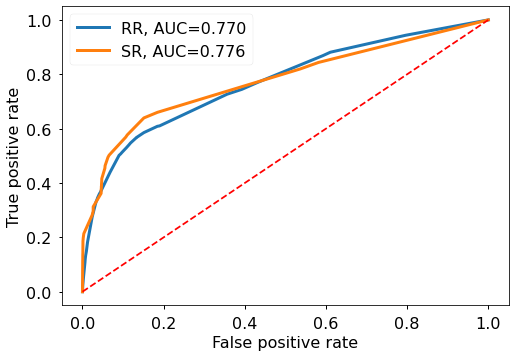

In [50]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

pred = target_clf.predict_proba(X_test)[:,1]
label = y_test
print(metrics.confusion_matrix(np.where(pred>0.05,1,0),label, labels=[1,0]))
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="RR, AUC={:.3f}".format(auc),linewidth=3)

pred = weighted_clf.predict_proba(X_test)[:,1]
print(metrics.confusion_matrix(np.where(pred>0.4,1,0),label,labels=[1,0]))
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="SR, AUC={:.3f}".format(auc),linewidth=3)
plt.plot(np.linspace(0,1),np.linspace(0,1),'r--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=0)
plt.savefig('COVID_ROC')
plt.show()

In [41]:
scores

[{'accuracy_score': 'LGBMClassifier',
  'RR': 0.9453375036368926,
  'RS': 0.5052643844365503,
  'SS': 0.7197562153752841,
  'SR': 0.8385583357579284},
 {'roc_auc_score': 'LGBMClassifier',
  'RR': 0.7764286030006863,
  'RS': 0.7191170751445064,
  'SS': 0.7591855676398758,
  'SR': 0.7774056353952685},
 {'confusion_matrix': 'LGBMClassifier',
  'RR': array([[51909,    42],
         [ 2964,    77]], dtype=int64),
  'RS': array([[0.09933784, 0.00059085],
         [0.09849196, 0.00185362]]),
  'SS': array([[0.08206162, 0.01786708],
         [0.03825854, 0.06208703]]),
  'SR': array([[44163,  7788],
         [ 1090,  1951]], dtype=int64)}]

In [14]:
target['Outcome'].sum() * 0.2 

2945.8

In [ ]:
print((marg_tab*100).round(3).to_latex())

In [ ]:
(100 - corpus.mean() * 100).round(1)

In [11]:
target['Outcome'].sum()

14729.0

In [ ]:
print(((marg_tab - rw_marg_tab)*100).round(4).to_latex())